In [1]:
from sklearn.preprocessing import QuantileTransformer

In [2]:
#Importing the Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mandates
#from sklearn.Preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

from keras.optimizers import gradient_descent_v2 
from keras.models import load_model
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

In [3]:
import plotly.graph_objects as go

In [4]:
from datetime import datetime
import pandas_datareader.data as web

stock = 'MSFT'
start = datetime(2019, 1, 1)

df = web.DataReader(stock, data_source='yahoo', start=start)

In [5]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,101.750000,98.940002,99.550003,101.120003,35329300.0,97.782433
2019-01-03,100.190002,97.199997,100.099998,97.400002,42579100.0,94.185211
2019-01-04,102.510002,98.930000,99.720001,101.930000,44060600.0,98.565681
2019-01-07,103.269997,100.980003,101.639999,102.059998,35656100.0,98.691383
2019-01-08,103.970001,101.709999,103.040001,102.800003,31514400.0,99.406990


In [6]:
#Print the shape of Dataframe  and Check for Null Values
print('Dataframe Shape: ', df. shape)
print('Null Value Present: ', df.isnull().values.any())

Dataframe Shape:  (748, 6)
Null Value Present:  False


The Adjusted Close Value is the final output value that will be forecasted using the Machine Learning model. This figure indicates the stock’s closing price on that particular day of stock market trading.

<AxesSubplot:xlabel='Date'>

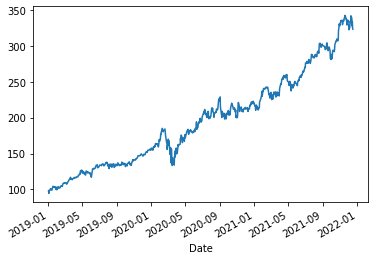

In [7]:
#Plot the True Adj Close Value
df['Adj Close'].plot()

Setting the Target Variable and Selecting the Features

The output column is then assigned to the target variable in the following step. It is the adjusted relative value of the Microsoft Stock in this situation. Furthermore, we pick the features that serve as the independent variable to the target variable (dependent variable). We choose four characteristics to account for training purposes:

    Open
    High
    Low
    Volume


In [8]:
#Set Target Variable
import pandas as pd
output_var = pd.DataFrame(df['Adj Close'])
#Selecting the Features
features = ['Open', 'High', 'Low', 'Volume']

Scaling

To decrease the computational cost of the data in the table, we will scale the stock values to values between 0 and 1. As a result, all of the data in large numbers is reduced, and therefore memory consumption is decreased. Also, because the data is not spread out in huge values, we can achieve greater precision by scaling down. To perform this we will be using the MinMaxScaler class of the sci-kit-learn library.

In [9]:
from sklearn.preprocessing import MinMaxScaler
#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform= pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()

,Open,High,Low,Volume
Date,,,,
2019-01-02,0.000000,0.006253,0.007102,0.299239
2019-01-03,0.002244,0.000000,0.000000,0.381602
2019-01-04,0.000694,0.009299,0.007061,0.398432
2019-01-07,0.008528,0.012346,0.015429,0.302952
2019-01-08,0.014241,0.015152,0.018408,0.255900


Creating a Training Set and a Test Set for Stock Market Prediction

We have to divide the entire dataset into training and test sets before feeding it into the training model. The Machine Learning LSTM model will be trained on the data in the training set and tested for accuracy and backpropagation on the test set.

The sci-kit-learn library’s TimeSeriesSplit class will be used for this. We set the number of splits to 10, indicating that 10% of the data will be used as the test set and 90% of the data would be used to train the LSTM model. The advantage of utilising this Time Series split is that the split time series data samples are examined at regular time intervals.

In [10]:
#Splitting to Training set and Test set
timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

Data Processing For LSTM

Once the training and test sets are finalized, we will input the data into the LSTM model. Before we can do that, we must transform the training and test set data into a format that the LSTM model can interpret. As the LSTM needs that the data to be provided in the 3D form, we first transform the training and test data to NumPy arrays and then restructure them to match into the format (Number of Samples, 1, Number of Features). Now, 706 are the number of samples in the training set, which is 90% of 784, and the number of features is 4, therefore the training set is reshaped to reflect this (706, 1, 4). Likewise, the test set is reshaped.

In [11]:
#Process the data for LSTM

trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

Building the LSTM Model for Stock Market Prediction

Finally, we arrive at the point when we will construct the LSTM Model. In this step, we’ll build a Sequential Keras model with one LSTM layer. The LSTM layer has 32 units and is followed by one Dense Layer of one neuron.

We compile the model using Adam Optimizer and the Mean Squared Error as the loss function. For an LSTM model, this is the most preferred combination. The model is plotted and presented below.

In [12]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')
plot_model(lstm, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Training the Stock Market Prediction Model

Finally, we use the fit function to train the LSTM model created above on the training data for 100 epochs with a batch size of 8.

In [13]:
#Model Training
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
85/85 [==============================] - 6s 4ms/step - loss: 36622.9492
Epoch 2/100
85/85 [==============================] - 0s 4ms/step - loss: 36299.5391
Epoch 3/100
85/85 [==============================] - 0s 5ms/step - loss: 35650.7109
Epoch 4/100
85/85 [==============================] - 0s 5ms/step - loss: 34541.9180
Epoch 5/100
85/85 [==============================] - 1s 6ms/step - loss: 32923.7305
Epoch 6/100
85/85 [==============================] - 0s 5ms/step - loss: 30837.2227
Epoch 7/100
85/85 [==============================] - 0s 4ms/step - loss: 28383.2891
Epoch 8/100
85/85 [==============================] - 0s 5ms/step - loss: 25684.5527
Epoch 9/100
85/85 [==============================] - 0s 4ms/step - loss: 22860.2129
Epoch 10/100
85/85 [==============================] - 0s 4ms/step - loss: 20014.9082
Epoch 11/100
85/85 [==============================] - 0s 6ms/step - loss: 17235.7656
Epoch 12/100
85/85 [==============================] - 0s 5ms/step - loss: 

Epoch 99/100
85/85 [==============================] - 0s 4ms/step - loss: 32.4102
Epoch 100/100
85/85 [==============================] - 0s 4ms/step - loss: 31.1759


Finally, we can observe that the loss value has dropped exponentially over time over the 100-epoch training procedure, reaching a value of 31.1759.

LSTM Prediction

Now that we have our model ready, we can use it to forecast the Adjacent Close Value of the Microsoft stock by using a model trained using the LSTM network on the test set. This is accomplished by employing the simple predict function on the LSTM model that has been created.

In [14]:
#LSTM Prediction
y_pred= lstm.predict(X_test)

Comparing Predicted vs True Adjusted Close Value – LSTM

Finally, now that we’ve projected the values for the test set, we can display the graph to compare both Adj Close’s true values and Adj Close’s predicted value using the LSTM Machine Learning model.

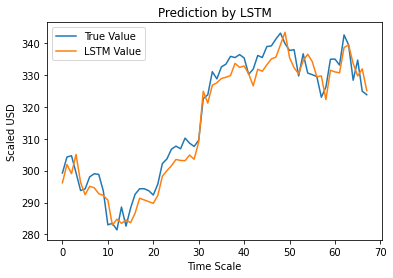

In [19]:
#Predicted vs True Adj Close Value – LSTM
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()